In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0532.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0282.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1401.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0914.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0691.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0972.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0818.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0463.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0930.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1323.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1347.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1354.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0704.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator


2025-10-03 20:25:48.521705: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759523148.768791      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759523148.833881      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


numpy (np) → Görselleri ve etiketleri array olarak tutmak, matematiksel işlemler yapmak için kullanıyoruz.

matplotlib.pyplot (plt) → Görselleştirme (örnek görüntüleri ve grafikler) için.

seaborn (sns) → Daha güzel ve anlaşılır istatistiksel grafikler için.

os → Dosya ve klasör yollarını yönetmek, klasörleri gezmek için.

cv2 (OpenCV) → Görselleri yüklemek, boyutlandırmak (resize) ve gri tonlamaya çevirmek için.

train_test_split (sklearn) → Veriyi eğitim, doğrulama ve test setlerine bölmek için.

to_categorical (Keras) → Etiketleri one-hot encoding’e çevirmek için. CNN sınıflandırma modellerinde gerekli.

ImageDataGenerator (Keras) → Data Augmentation (veri çoğaltma) yapmak için. Modelin daha iyi öğrenmesini sağlar.

In [4]:


IMG_SIZE = 128
class_names = []


dataset_base_path → Datasetin Kaggle’daki yolu.

IMG_SIZE → Görselleri CNN’e uygun boyuta getirmek için 128x128 seçtik.

class_names → Sınıf isimlerini kaydetmek için.

In [6]:
def load_images_from_folder(base_path):
    X = []
    y = []
    for class_dir in os.listdir(base_path):
        class_path = os.path.join(base_path, class_dir)
        if os.path.isdir(class_path):
            if class_dir not in class_names:
                class_names.append(class_dir)
            class_index = class_names.index(class_dir)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                try:
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                        X.append(img)
                        y.append(class_index)
                except:
                    continue
    return np.array(X), np.array(y)

Bu fonksiyon, bir klasör yapısındaki resimleri okuyup CNN modeline uygun şekilde hazırlamak için kullanılır.

os.listdir() ve os.path.join() → Her sınıf klasörünü ve içindeki görselleri bulmak için.

cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) → Görseli gri tonlamaya çeviriyoruz, çünkü MR görüntüleri zaten siyah-beyaz.

cv2.resize(img, (IMG_SIZE, IMG_SIZE)) → Görseli 128x128 boyutuna getiriyoruz.

X.append(img), y.append(class_names.index(class_dir)) → Görselleri ve etiketlerini listelere ekliyoruz.

In [7]:

# Training verisini yüklüyoruz
X_train, y_train = load_images_from_folder('/kaggle/input/brain-tumor-mri-dataset/Training')

# 2. Test verisini yüklüyoruz
X_test, y_test = load_images_from_folder('/kaggle/input/brain-tumor-mri-dataset/Testing')

# 3. Validation setini Training'den ayırıyoruz
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42, stratify=y_train
)

Training verisi yükleniyor: X_train, y_train → eğitim için görüntü ve etiketler.

Test verisi yükleniyor: X_test, y_test → modelin performansını değerlendirmek için.

Validation seti ayrılıyor: X_val, y_val → eğitim sırasında modelin doğruluğunu kontrol etmek için, training setinin %15’i ayrılıyor ve sınıf dağılımı korunuyor

In [8]:


X_train = X_train / 255.0
X_val   = X_val / 255.0
X_test  = X_test / 255.0

X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_val   = X_val.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_test  = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)


Piksel değerlerini 0–255 aralığından 0–1 aralığına çekiyoruz, CNN ile çalışması için.

CNN input formatına uyumlu hale getiriyoruz: (örnek_sayısı, yükseklik, genişlik, kanal). Tek kanal olduğu için 1 yazıyoruz (grayscale).

In [9]:
y_train_cat = to_categorical(y_train, num_classes=len(class_names))
y_val_cat = to_categorical(y_val, num_classes=len(class_names))
y_test_cat = to_categorical(y_test, num_classes=len(class_names))


CNN için etiketler one-hot encoding formatına çevrildi.
Örn: 4 sınıf varsa [1,0,0,0], [0,1,0,0] gibi.

In [10]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)


Data Augmentation (Veri Çoğaltma)
Modelin overfit olmaması ve daha iyi genelleme yapması için veri çoğaltma (augmentation) yaptık:

rotation_range=20 → Görselleri 20° döndürebilir

width_shift_range / height_shift_range → Görselleri kaydırabilir

zoom_range → Yakınlaştırma

horizontal_flip → Yatay çevirme

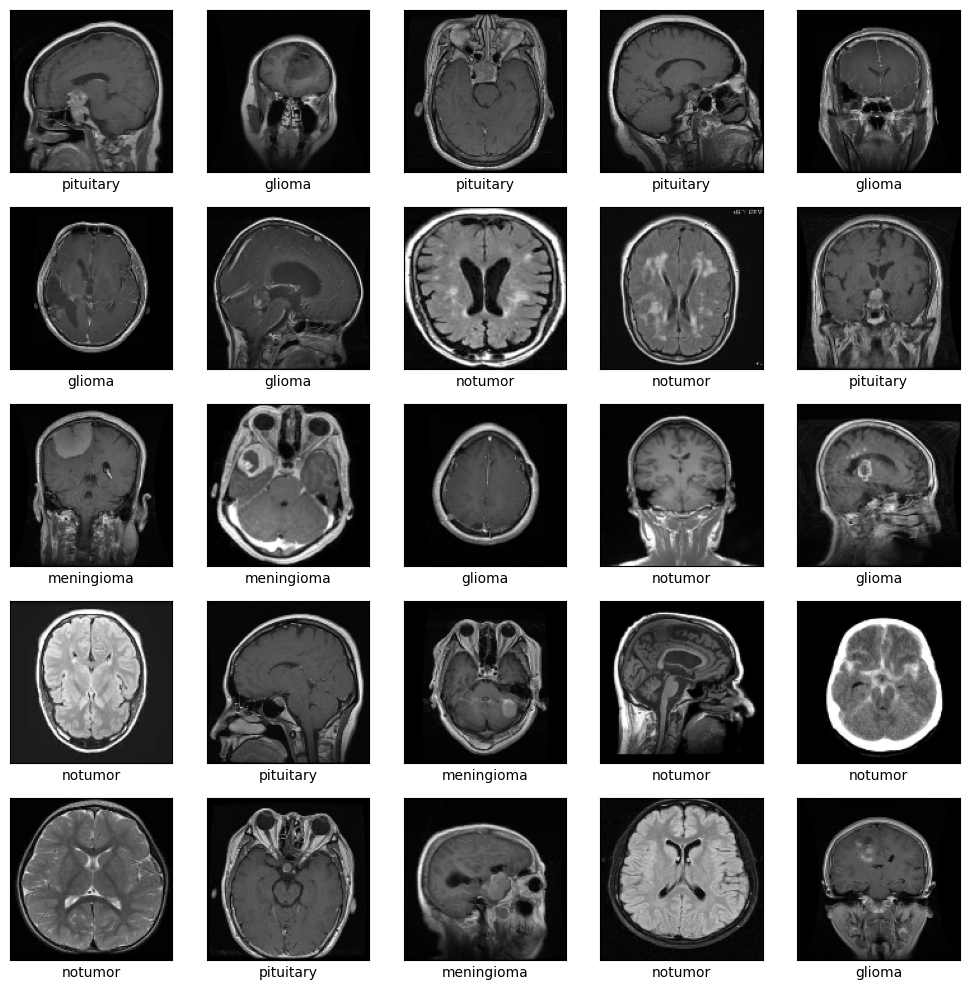

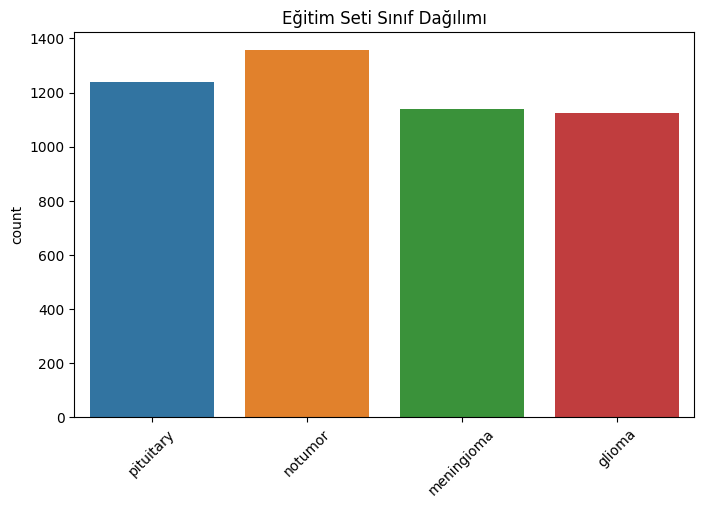

In [11]:
# Örnek görseller
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([]); plt.yticks([]); plt.grid(False)
    plt.imshow(X_train[i].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    plt.xlabel(class_names[y_train[i]])
plt.tight_layout()
plt.show()

# Sınıf dağılımı
plt.figure(figsize=(8,5))
sns.countplot(x=y_train)
plt.title("Eğitim Seti Sınıf Dağılımı")
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=45)
plt.show()


Bu adımla veri seti CNN’e hazır hale geliyor:

Görseller normalize ve resize edildi

Train/Validation/Test setleri hazır

One-hot encoding uygulandı

Augmentation hazır

Görselleştirme ile veri dağılımı kontrol edildi

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint

In [13]:
model = Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 1)),   # Giriş katmanı
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    
    Dropout(0.25),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

I0000 00:00:1759523330.374301      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1759523330.375011      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Giriş katmanı: Gri tonlamalı (1 kanallı) ve boyutu IMG_SIZE x IMG_SIZE olan görüntüleri alacak şekilde tanımlandı.

Konvolüsyon + MaxPooling katmanları: Görüntüden özellikleri çıkarmak ve boyutu küçültmek için 3 blok halinde uygulandı (32→64→128 filtre).

Dropout: Overfitting’i önlemek için ara katmanlarda nöronların rastgele kapatılması sağlandı (%25 ve %50).

Flatten: 2D feature map’ler 1D vektöre dönüştürüldü, dense katmana bağlanabilmesi için.

Dense katmanlar:

128 nöronlu ara katman, öğrenilen özellikleri birleştirdi.

Çıkış katmanı, sınıf sayısı kadar nöron ile softmax aktivasyonu kullanarak her sınıfa ait olasılık tahmini yaptı.

In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Modeli Derlemek

optimizer='adam' → Modelin ağırlıklarını güncellemek için hızlı ve etkili bir optimizasyon algoritması.

loss='categorical_crossentropy' → Çok sınıflı sınıflandırma için uygun kayıp fonksiyonu.

metrics=['accuracy'] → Eğitim ve doğrulama sırasında doğruluk değerlerini takip ederiz.

In [16]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)


Model Checkpoint Oluşturmak

Modeli her epoch sonunda değerlendirir ve en düşük validation loss’a sahip modeli kaydeder.
Böylece eğitim sırasında en iyi model kaybolmaz ve son modelin kötü performans göstermesi önlenir.

In [17]:
history = model.fit(
    datagen.flow(X_train, y_train_cat, batch_size=32),
    validation_data=(X_val, y_val_cat),
    epochs=20,
    callbacks=[checkpoint]
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1759523422.371990     100 service.cc:148] XLA service 0x793b98005940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759523422.373150     100 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1759523422.373175     100 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1759523422.703809     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/152 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.2663 - loss: 1.3926

I0000 00:00:1759523426.718380     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.4697 - loss: 1.1459
Epoch 1: val_loss improved from inf to 1.11714, saving model to best_model.h5
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.4712 - loss: 1.1436 - val_accuracy: 0.5694 - val_loss: 1.1171
Epoch 2/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6975 - loss: 0.7483
Epoch 2: val_loss improved from 1.11714 to 0.94227, saving model to best_model.h5
152/152 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.6976 - loss: 0.7480 - val_accuracy: 0.6744 - val_loss: 0.9423
Epoch 3/20
151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7427 - loss: 0.6436
Epoch 3: val_loss improved from 0.94227 to 0.56650, saving model to best_model.h5
152/152 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.7429 - loss: 0.6434 - val_accuracy: 0.7888 - val_loss: 0.5665
Epoch 4/20
151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7814 - loss: 0.5800
Epoch 4: val_loss did not improve from 0.56650
152/152 ━━━━━━━━━━━

Modeli Eğitmek

datagen.flow → Data Augmentation uygular, eğitim verisini artırır ve modelin genelleme yeteneğini artırır.

validation_data → Her epoch sonunda validation seti ile modelin performansı kontrol edilir.

epochs=20 → Model veriyi 20 kez görerek öğrenir.

callbacks=[checkpoint] → En iyi modeli kaydeder.

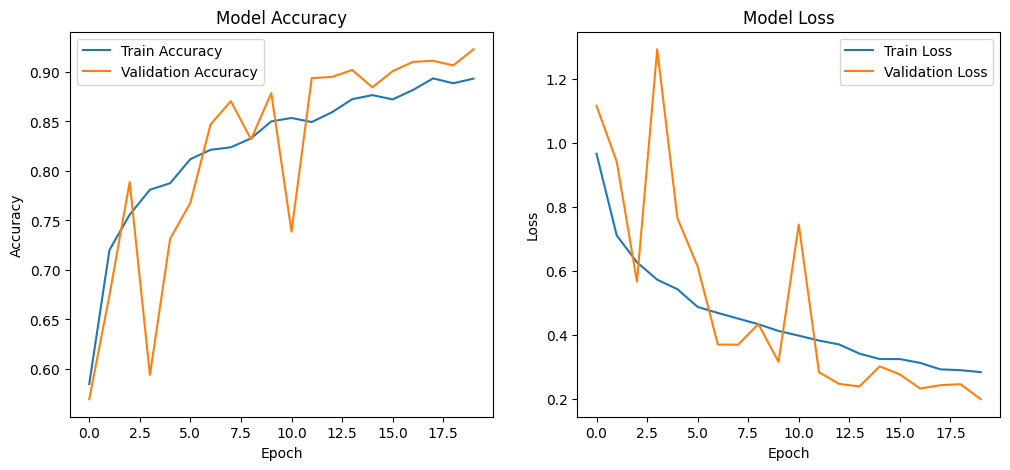

In [18]:
# Accuracy ve Loss grafikleri
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


Accuracy ve Loss Grafikleri


Eğitim sürecinde modelin nasıl ilerlediğini görmek. Overfitting veya underfitting olup olmadığını kontrol ederiz.
history.history['accuracy'] → Her epoch’taki eğitim doğruluğu

history.history['val_accuracy'] → Her epoch’taki doğrulama doğruluğu

Aynı şekilde loss ile kayıp değerlerini gösteriyoruz

In [19]:
# Modeli "build" et
model.build(input_shape=(None, IMG_SIZE, IMG_SIZE, 1))
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,913,742 (37.82 MB)

 Trainable params: 3,304,580 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,609,162 (25.21 MB)

Modelin giriş boyutunu belirleyip katmanları oluşturuyor (build), ardından modelin yapısını ve parametre sayılarını özet olarak gösteriyor (summary).

In [20]:
from tensorflow.keras.utils import to_categorical

# Eğer y_test sayısal sınıf etiketlerinden oluşuyorsa:
y_test_categorical = to_categorical(y_test, num_classes=len(class_names))


Bu kod, y_test’teki sayısal sınıf etiketlerini one-hot encoding formatına çevirir.

Örneğin 4 sınıf varsa, 0 → [1,0,0,0], 1 → [0,1,0,0] şeklinde olur.

CNN veya diğer sinir ağı modellerinde sınıflandırma katmanıyla uyumlu olması için etiketlerin bu formata çevrilmesi gerekir.

Test Loss: 0.3204
Test Accuracy: 0.8696

Classification Report:
              precision    recall  f1-score   support

   pituitary       0.94      0.98      0.96       300
     notumor       0.83      1.00      0.91       405
  meningioma       0.77      0.72      0.75       306
      glioma       0.97      0.73      0.84       300

    accuracy                           0.87      1311
   macro avg       0.88      0.86      0.86      1311
weighted avg       0.88      0.87      0.87      1311



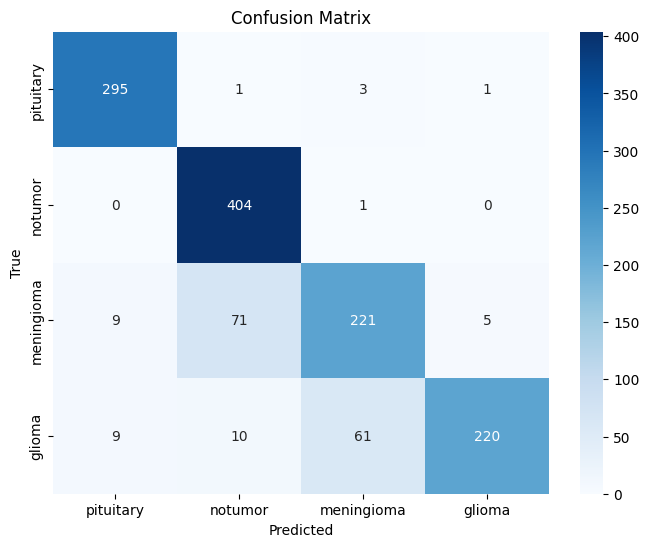

<Figure size 1200x800 with 0 Axes>

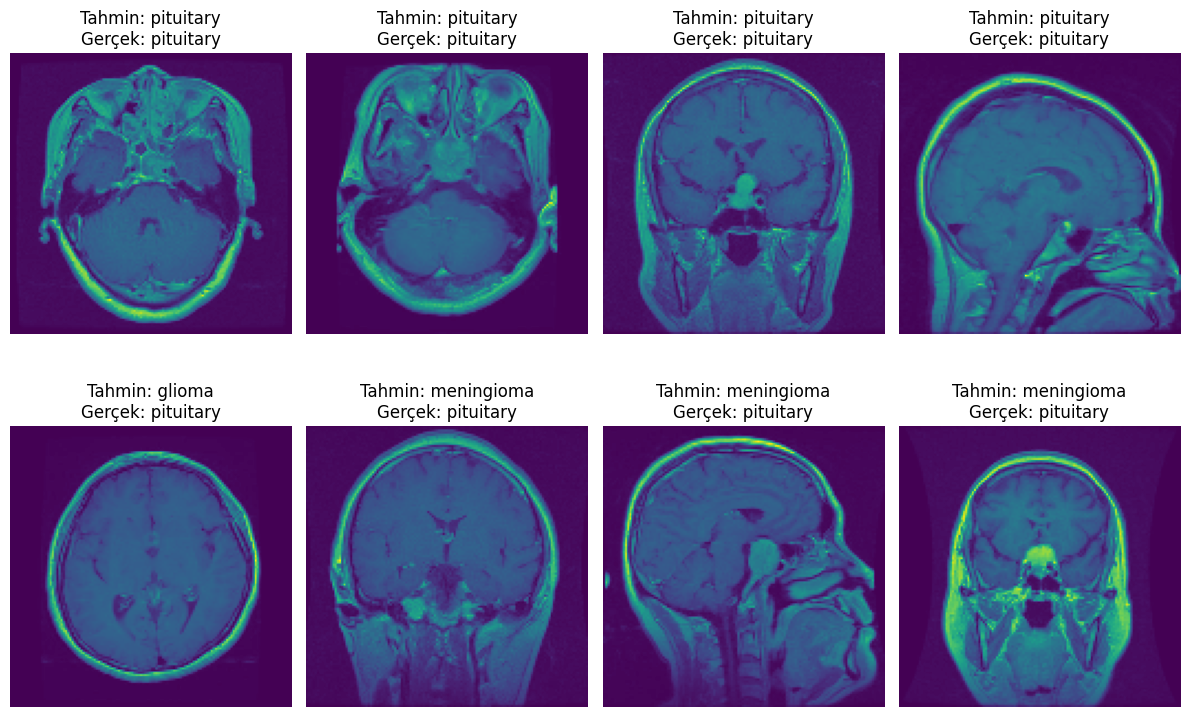

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


test_loss, test_acc = model.evaluate(X_test, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


y_pred_prob = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)


print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))


cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

correct_indices = np.where(y_pred == y_test)[0]
incorrect_indices = np.where(y_pred != y_test)[0]

plt.figure(figsize=(12, 8))


correct_indices = np.where(y_pred == y_test)[0]
incorrect_indices = np.where(y_pred != y_test)[0]

plt.figure(figsize=(12, 8))

for i, correct in enumerate(correct_indices[:4]):
    plt.subplot(2, 4, i+1)
    plt.imshow(X_test[correct].squeeze(), cmap="gray") # squeeze = (128,128,1) -> (128,128)
    plt.title(f"Tahmin: {class_names[y_pred[correct]]}\nGerçek: {class_names[y_test[correct]]}")
    plt.axis('off')


for i, correct in enumerate(correct_indices[:4]):
    plt.subplot(2, 4, i+1)
    plt.imshow(X_test[correct])
    plt.title(f"Tahmin: {class_names[y_pred[correct]]}\nGerçek: {class_names[y_test[correct]]}")
    plt.axis('off')


for i, incorrect in enumerate(incorrect_indices[:4]):
    plt.subplot(2, 4, i+5)
    plt.imshow(X_test[incorrect])
    plt.title(f"Tahmin: {class_names[y_pred[incorrect]]}\nGerçek: {class_names[y_test[incorrect]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

Heatmap Görselleştirme (Grad-CAM)



Modelin hangi görüntü bölgelerine bakarak sınıflandırma yaptığını görselleştirmek. Özellikle medikal görüntüde önemlidir.

Bu kod, eğittiğimiz CNN modelinin test verisi üzerindeki performansını ölçmek ve sonuçları görselleştirmek için kullanılır.

Önce modelin test seti üzerindeki kayıp (loss) ve doğruluk (accuracy) değerleri hesaplanır.

Modelin tahminleri alınır ve her örnek için en olası sınıf seçilir.

Classification Report ile her sınıf için precision, recall, f1-score gibi metrikler değerlendirilir.

Confusion Matrix ile modelin hangi sınıflarda doğru veya yanlış tahminler yaptığı görselleştirilir.

Son olarak, bazı doğru ve yanlış tahmin örnekleri görselleştirilerek modelin kararları görsel olarak incelenir.

Bu sayede hem sayısal hem görsel olarak modelin performansı anlaşılır.

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import HyperModel, RandomSearch
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

# Eğer y_train ve y_val integer etiketler ise
y_train_categorical = to_categorical(y_train, num_classes=len(class_names))
y_val_categorical = to_categorical(y_val, num_classes=len(class_names))
y_test_categorical = to_categorical(y_test, num_classes=len(class_names))

# Hiperparametre optimizasyonu için HyperModel
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
    
    def build(self, hp):
        model = keras.Sequential()
        model.add(layers.Input(shape=self.input_shape))
        
        # Conv katman sayısı
        for i in range(hp.Int('conv_layers', 1, 3)):
            model.add(layers.Conv2D(
                filters=hp.Int(f'filters_{i}', min_value=16, max_value=64, step=16),
                kernel_size=hp.Choice(f'kernel_size_{i}', values=[3,5]),
                activation='relu',
                padding='same'
            ))
            model.add(layers.MaxPooling2D(pool_size=(2,2)))
            # Dropout
            model.add(layers.Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))
        
        model.add(layers.Flatten())
        # Dense layer boyutu
        model.add(layers.Dense(
            units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
            activation='relu'
        ))
        model.add(layers.Dropout(rate=hp.Float('dense_dropout', min_value=0.0, max_value=0.5, step=0.1)))
        model.add(layers.Dense(self.num_classes, activation='softmax'))
        
        # Optimizer ve learning rate
        optimizer = keras.optimizers.Adam(
            learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
        )
        
        model.compile(optimizer=optimizer,
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        return model

# Parametreler
input_shape = (128, 128, 1)  # örnek, grayscale
num_classes = len(class_names)  # sınıf sayısı

# HyperModel oluştur
hypermodel = CNNHyperModel(input_shape=input_shape, num_classes=num_classes)

# Random Search ile optimizasyon
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=3,  # denenecek farklı kombinasyon sayısı
    executions_per_trial=1,
    directory='cnn_tuner',
    project_name='hyperparam_opt'
)

# TensorBoard callback (isteğe bağlı)
tensorboard_cb = keras.callbacks.TensorBoard(log_dir='./logs')

# Hiperparametre araması
tuner.search(
    X_train, y_train_categorical,
    epochs=20,
    validation_data=(X_val, y_val_categorical),
    batch_size=32,  # istenirse tuner ile değiştirilebilir
    callbacks=[tensorboard_cb]
)

# En iyi modeli al
best_model = tuner.get_best_models(num_models=1)[0]

# Modelin özetini yazdır
best_model.summary()


Trial 3 Complete [00h 00m 57s]
val_accuracy: 0.9218202829360962

Best val_accuracy So Far: 0.9264877438545227
Total elapsed time: 00h 02m 44s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    16,777,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,778,180 (64.00 MB)

 Trainable params: 16,778,180 (64.00 MB)

 Non-trainable params: 0 (0.00 B)

Bu kod, bir CNN modeli için hiperparametre optimizasyonu yapmayı ve en iyi modeli seçip performansını görselleştirmeyi sağlar.

Öncelikle, eğitim, doğrulama ve test setlerindeki sınıf etiketleri one-hot encoding formatına çevrilir; bu, CNN’in sınıfları doğru şekilde öğrenebilmesi için gereklidir.

Daha sonra CNNHyperModel sınıfı tanımlanır. Bu sınıf, modelin yapısını ve optimize edilecek hiperparametreleri belirtir. Örneğin:

Konvolüsyon katmanı sayısı

Filtre sayısı ve boyutları

Dropout oranları

Dense katman boyutu

Öğrenme oranı (learning rate)

RandomSearch kullanılarak farklı hiperparametre kombinasyonları denenir ve doğrulama seti üzerinden en iyi doğruluk elde eden model seçilir.

Bu süreç, modelin hem daha doğru hem de genelleme yeteneği yüksek bir şekilde optimize edilmesini sağlar.

Epoch 1/14


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.6509 - loss: 1.1807 - val_accuracy: 0.8740 - val_loss: 0.3397
Epoch 2/14
152/152 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.6932 - loss: 0.8025 - val_accuracy: 0.8868 - val_loss: 0.3680
Epoch 3/14
152/152 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.7221 - loss: 0.7308 - val_accuracy: 0.8448 - val_loss: 0.4878
Epoch 4/14
152/152 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.7420 - loss: 0.6768 - val_accuracy: 0.8670 - val_loss: 0.3839
Epoch 5/14
152/152 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.7620 - loss: 0.6243 - val_accuracy: 0.8821 - val_loss: 0.3754
Epoch 6/14
152/152 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.7430 - loss: 0.6482 - val_accuracy: 0.8623 - val_loss: 0.3858
Epoch 7/14
152/152 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.7606 - loss: 0.6064 - val_accuracy: 0.8436 - val_loss: 0.4398
Epoch 8/14
152/152 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.7663 - loss: 0.6130 - val_accuracy: 0.862

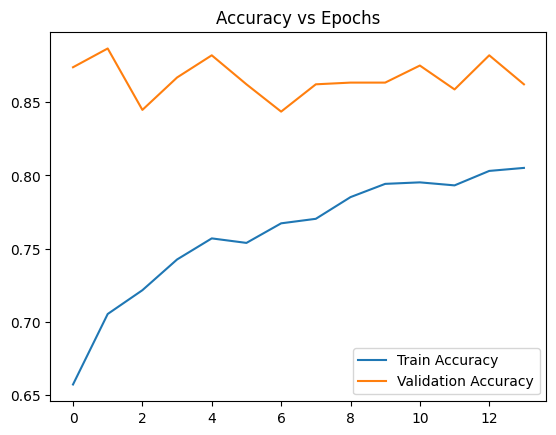

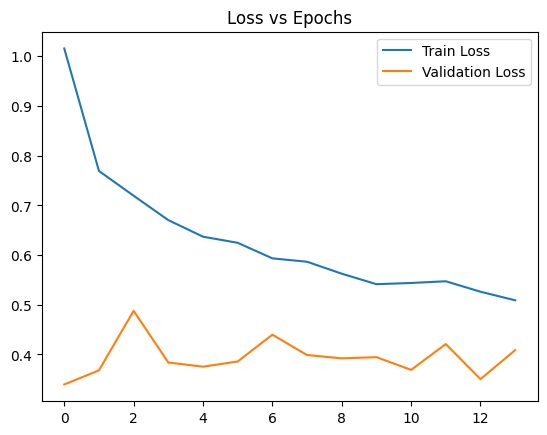

In [23]:
best_model = tuner.get_best_models(num_models=1)[0]

history = best_model.fit(
    datagen.flow(X_train, y_train_cat, batch_size=32),
    validation_data=(X_val, y_val_cat),
    epochs=14
)

# Accuracy ve Loss grafikleri
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()


Eğitim ve Overfitting/Underfitting Kontrolü

daha önce hiperparametre optimizasyonu ile bulunan en iyi CNN modelini (best_model) alır ve eğitim sürecine başlar. Eğitim sırasında, datagen.flow kullanılarak veri artırımı (data augmentation) uygulanır; bu sayede model farklı varyasyonlardaki görüntülerle eğitilir ve overfitting riski azalır. Model, 20 epoch boyunca eğitim (X_train, y_train_cat) ve doğrulama (X_val, y_val_cat) verileri üzerinde optimize edilir.

Eğitim tamamlandıktan sonra, history objesi sayesinde eğitim ve doğrulama doğruluğu (accuracy) ile kayıp (loss) değerleri takip edilir. Bu değerler matplotlib kullanılarak grafiklerle görselleştirilir:

Accuracy grafiği: Eğitim doğruluğu sürekli artarken doğrulama doğruluğu bir noktada duruyor veya düşüyorsa, model veriye fazla uyum sağlamış ve overfitting yapıyor demektir. Eğer her iki doğruluk da düşükse, model veriyi yeterince öğrenememiş ve underfitting söz konusudur.

Loss grafiği: Eğitim kaybı düşerken doğrulama kaybı yükseliyorsa yine overfitting vardır. Her iki kayıp yüksekse, model yeterince öğrenememiştir (underfitting).

Bu sayede modelin hem performansı hem de genelleme yeteneği görsel olarak değerlendirilebilir.

In [24]:
from tensorflow.keras.callbacks import TensorBoard
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history = best_model.fit(
    datagen.flow(X_train, y_train_cat, batch_size=32),
    validation_data=(X_val, y_val_cat),
    epochs=10,
    callbacks=[tensorboard_callback]
)


Epoch 1/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.7925 - loss: 0.5254 - val_accuracy: 0.8471 - val_loss: 0.4348
Epoch 2/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.7971 - loss: 0.5118 - val_accuracy: 0.8401 - val_loss: 0.4128
Epoch 3/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.7996 - loss: 0.5091 - val_accuracy: 0.8530 - val_loss: 0.3868
Epoch 4/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.8233 - loss: 0.4778 - val_accuracy: 0.8401 - val_loss: 0.4606
Epoch 5/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.8128 - loss: 0.4671 - val_accuracy: 0.8798 - val_loss: 0.3441
Epoch 6/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.8238 - loss: 0.4651 - val_accuracy: 0.8670 - val_loss: 0.3484
Epoch 7/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.8087 - loss: 0.4794 - val_accuracy: 0.8786 - val_loss: 0.3411
Epoch 8/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.8139 - loss: 0.4649 - val_accu

TensorBoard callback ayarlanması:

log_dir ile eğitim sırasında oluşturulacak log dosyalarının konumu belirlenir. Burada tarih ve saat bilgisi ile benzersiz bir klasör ismi oluşturulur, böylece farklı eğitimler ayrı loglarda saklanır.

tensorboard_callback = TensorBoard(...) ile TensorBoard’a logları kaydetmesi ve histogramları (histogram_freq=1) oluşturması söylenir. Histogramlar, ağırlık dağılımlarını ve aktivasyonları görselleştirmek için kullanılır.

Modelin eğitilmesi:

best_model.fit(...) ile daha önce hiperparametre optimizasyonu sonucu seçilen en iyi model eğitilir.

datagen.flow(...) ile veri artırımı uygulanır, yani eğitim sırasında görüntüler rastgele döndürülür, ölçeklenir veya değiştirilir; bu, overfitting’i azaltır.

validation_data=(X_val, y_val_cat) ile her epoch sonunda modelin doğrulama seti üzerindeki performansı da ölçülür.

callbacks=[tensorboard_callback] ile eğitim sırasında loglar TensorBoard’a kaydedilir, böylece eğitim ve doğrulama kaybı, doğruluk, ağırlık dağılımları gibi bilgiler görselleştirilebilir.

Bu kod sayesinde modelin öğrenme süreci hem görselleştirilebilir hem de detaylı olarak analiz edilebilir.